In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [2]:
# Paths
base_path = "/kaggle/input/udacity-self-driving-car-behavioural-cloning"
jungle_src = os.path.join(base_path, "self_driving_car_dataset_jungle")
lake_src = os.path.join(base_path, "self_driving_car_dataset_make")
dest = "./dataset"

In [3]:
# Copy both datasets
if os.path.exists(dest):
    shutil.rmtree(dest)
shutil.copytree(jungle_src, dest, dirs_exist_ok=True)
shutil.copytree(lake_src, os.path.join(dest, "make"), dirs_exist_ok=True)

'./dataset/make'

In [4]:
# Verify copied files
img_dir = "./dataset/IMG"
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
jungle_img_files = [f for f in os.listdir(os.path.join(jungle_src, "IMG")) if f.endswith(('.jpg', '.jpeg'))]
lake_img_files = [f for f in os.listdir(os.path.join(lake_src, "IMG")) if f.endswith(('.jpg', '.jpeg'))]
for filename in jungle_img_files:
    src_path = os.path.join(jungle_src, "IMG", filename)
    dest_path = os.path.join(img_dir, filename)
    if not os.path.exists(dest_path):
        shutil.copy2(src_path, dest_path)
for filename in lake_img_files:
    src_path = os.path.join(lake_src, "IMG", filename)
    dest_path = os.path.join(img_dir, filename)
    if not os.path.exists(dest_path):
        shutil.copy2(src_path, dest_path)
print(f"Total images copied to {img_dir}: {len(os.listdir(img_dir))}")

Total images copied to ./dataset/IMG: 22002


In [5]:
# Load and combine CSV data
column_names = ["centercam", "leftcam", "rightcam", "steering_angle", "throttle", "reverse", "speed"]
jungle_df = pd.read_csv(os.path.join(jungle_src, "driving_log.csv"), names=column_names, header=None)
lake_df = pd.read_csv(os.path.join(lake_src, "driving_log.csv"), names=column_names, header=None)
jungle_df["source"] = "jungle"
lake_df["source"] = "lake"
df = pd.concat([jungle_df, lake_df], ignore_index=True)
df = df[["centercam", "steering_angle", "throttle", "speed"]]  # Include throttle and speed
print("Combined CSV shape:", df.shape)

Combined CSV shape: (7334, 4)


In [6]:
# Extract filenames
df["centercam"] = df["centercam"].apply(lambda x: x.split("\\")[-1])
print("First 5 records:\n", df.head())

First 5 records:
                             centercam  steering_angle  throttle     speed
0  center_2022_04_10_12_44_27_913.jpg            0.00       1.0  21.69488
1  center_2022_04_10_12_44_27_983.jpg            0.00       1.0  22.50011
2  center_2022_04_10_12_44_28_052.jpg            0.00       1.0  23.11461
3  center_2022_04_10_12_44_28_121.jpg            0.00       1.0  23.89061
4  center_2022_04_10_12_44_28_191.jpg            0.05       1.0  24.46815


Steering angle stats:
 count    7334.000000
mean       -0.015585
std         0.321524
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering_angle, dtype: float64


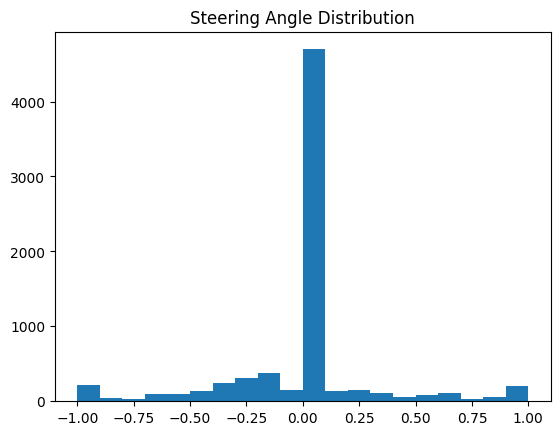

In [7]:
# Stats and visualization
print("Steering angle stats:\n", df["steering_angle"].describe())
plt.hist(df["steering_angle"].values, bins=20)
plt.title("Steering Angle Distribution")
plt.show()

In [8]:
# Filter non-zero angles and sample zero angles
non_zero_df = df[df["steering_angle"] != 0.0]
zero_df = df[df["steering_angle"] == 0.0].sample(frac=0.05)  # 5% of zero angles
print("Non-zero shape:", non_zero_df.shape, "Zero shape:", zero_df.shape)

Non-zero shape: (2802, 4) Zero shape: (227, 4)


In [9]:
# Augmentation
img_dir = "./dataset/IMG"
images = []
labels = []
throttles = []
speeds = []

def augment_and_save(img_dir, img_name, label, throttle, speed):
    img_path = os.path.join(img_dir, img_name)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        new_img_name = img_name.replace(".jpg", "_flipped.jpg")
        new_img_path = os.path.join(img_dir, new_img_name)
        cv2.imwrite(new_img_path, cv2.flip(img, 1))
        return (new_img_name, -label, throttle, speed)
    return (None, None, None, None)

In [10]:
for index, data in non_zero_df.iterrows():
    image, label, throttle, speed = augment_and_save(img_dir, data["centercam"], data["steering_angle"], data["throttle"], data["speed"])
    if image is not None:
        images.append(image)
        labels.append(label)
        throttles.append(throttle)
        speeds.append(speed)

In [11]:
# Combine datasets
augmented_df = pd.DataFrame(list(zip(images, labels, throttles, speeds)), columns=["centercam", "steering_angle", "throttle", "speed"])
new_train_df = pd.concat([zero_df, augmented_df, non_zero_df])
print("New train shape:", new_train_df.shape)

New train shape: (5831, 4)


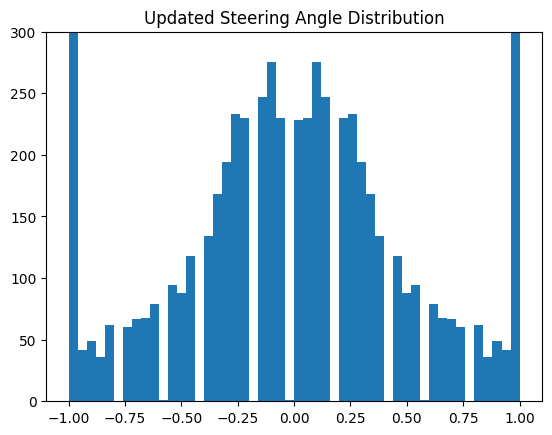

In [12]:
# Visualize updated distribution
plt.ylim(0, 300)
plt.hist(new_train_df["steering_angle"].values, bins=50)
plt.title("Updated Steering Angle Distribution")
plt.show()

In [13]:
# Custom Dataset with error handling
class DrivingDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df["centercam"].iloc[idx]
        img_path = os.path.join(self.img_dir, img_name)
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = self.df["steering_angle"].iloc[idx]
                throttle = self.df["throttle"].iloc[idx]
                speed = self.df["speed"].iloc[idx]
                if self.transform:
                    img = self.transform(img)
                return img, torch.tensor([throttle, speed], dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
        # Return a dummy sample if image fails to load
        print(f"Warning: Failed to load {img_path}, skipping.")
        dummy_img = np.zeros((224, 224, 3), dtype=np.uint8)
        return self.transform(dummy_img), torch.tensor([0.0, 0.0], dtype=torch.float32), torch.tensor(0.0, dtype=torch.float32)

In [14]:
# Transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
# Create datasets and dataloaders
dataset = DrivingDataset(new_train_df, img_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [16]:
# ResNet Model with additional inputs
class SteeringModel(nn.Module):
    def __init__(self):
        super(SteeringModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove the final layer
        self.fc1 = nn.Linear(num_ftrs + 2, 128)  # +2 for throttle and speed
        self.fc2 = nn.Linear(128, 1)  # Output steering angle

    def forward(self, x, extra_features):
        x = self.resnet(x)
        x = torch.cat((x, extra_features), dim=1)  # Concatenate image and numerical features
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
model = SteeringModel().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


In [18]:
# Training loop
epochs = 25

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, extra_features, angles in train_loader:
        images, extra_features, angles = images.cuda(), extra_features.cuda(), angles.cuda().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images, extra_features)
        loss = criterion(outputs, angles)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch}, Train Loss: {train_loss / len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, extra_features, angles in val_loader:
            images, extra_features, angles = images.cuda(), extra_features.cuda(), angles.cuda().unsqueeze(1)
            outputs = model(images, extra_features)
            val_loss += criterion(outputs, angles).item()
    print(f"Validation Loss: {val_loss / len(val_loader)}")

Epoch 0, Train Loss: 0.11210554580472104
Validation Loss: 0.07666657406937431
Epoch 1, Train Loss: 0.056852747915848476
Validation Loss: 0.07396676074210051
Epoch 2, Train Loss: 0.033360139122360376
Validation Loss: 0.07296312127161671
Epoch 3, Train Loss: 0.02372319750768477
Validation Loss: 0.0662310050951468
Epoch 4, Train Loss: 0.015905077524534236
Validation Loss: 0.06334584458051501
Epoch 5, Train Loss: 0.01343527119223998
Validation Loss: 0.06350430816009238
Epoch 6, Train Loss: 0.01127538038736643
Validation Loss: 0.06333544518093805
Epoch 7, Train Loss: 0.009502813929679154
Validation Loss: 0.060406208944481773
Epoch 8, Train Loss: 0.008871776632301202
Validation Loss: 0.060963629518409036
Epoch 9, Train Loss: 0.009537342281961073
Validation Loss: 0.060800569786413294
Epoch 10, Train Loss: 0.008269984836447728
Validation Loss: 0.06700509957767822
Epoch 11, Train Loss: 0.008208133835243443
Validation Loss: 0.06063992555278379
Epoch 12, Train Loss: 0.007984019187597991
Validatio

A validation MSE of ~0.056 translates to a root mean squared error (RMSE) of ~0.237, meaning the average steering angle prediction error is about 0.237 radians (or ~13.6 degrees). This is reasonable for a baseline but could be improved for precise control.

In [19]:
# Save model
torch.save(model.state_dict(), "steering_model.pth")

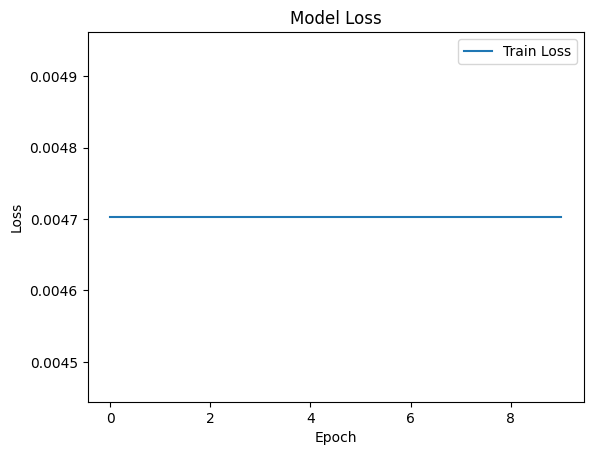

In [20]:
# Visualize training history
plt.plot([i for i in range(10)], [train_loss / len(train_loader) for i in range(10)], label="Train Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Test Run

In [21]:
# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SteeringModel().to(device)
model.load_state_dict(torch.load("/kaggle/input/steering-beh/steering_model.pth", map_location=device))
model.eval()

# Define transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
# Load and preprocess image
img_path = "/kaggle/input/udacity-self-driving-car-behavioural-cloning/self_driving_car_dataset_make/IMG/center_2022_04_10_12_24_42_463.jpg"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Keep original for display
img_tensor = transform(img_rgb).unsqueeze(0).to(device)

# Define extra features (throttle, speed)
throttle = 0.5  # Example value (0 to 1)
speed = 20.0    # Example value (e.g., km/h or simulator units)
extra_features = torch.tensor([[throttle, speed]], dtype=torch.float32).to(device)

In [23]:
# Predict
with torch.no_grad():
    prediction = model(img_tensor, extra_features).item()
print("Predicted steering angle:", prediction, "radians")
angle_deg = prediction * 30  # Scale -1 to 1 -> -30° to 30° for visualization
print("Predicted steering angle:", angle_deg, "degrees")

Predicted steering angle: -0.20265671610832214 radians
Predicted steering angle: -6.079701483249664 degrees


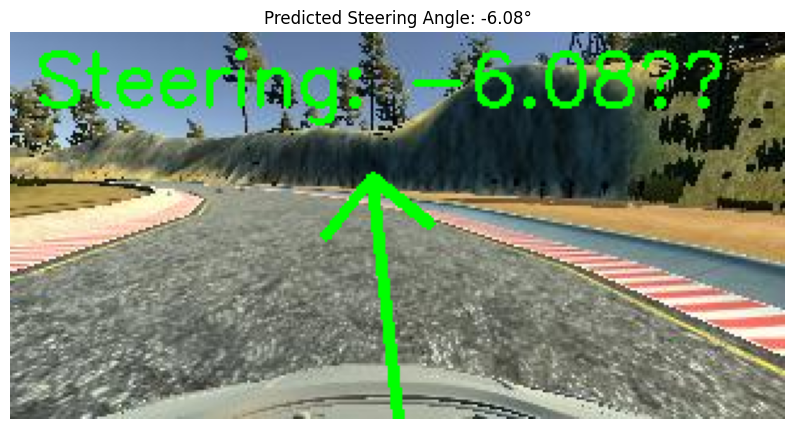

In [24]:
# Visualize image with prediction
plt.figure(figsize=(10, 6))
height, width = img_rgb.shape[:2]
center_x, center_y = width // 2, height
length = 100
end_x = int(center_x + length * np.sin(np.radians(angle_deg)))
end_y = int(center_y - length * np.cos(np.radians(angle_deg)))
img_with_arrow = img_rgb.copy()
cv2.arrowedLine(img_with_arrow, (center_x, center_y), (end_x, end_y), (0, 255, 0), 3, tipLength=0.3)
cv2.putText(img_with_arrow, f"Steering: {angle_deg:.2f}°", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(img_with_arrow)
plt.title(f"Predicted Steering Angle: {angle_deg:.2f}°")
plt.axis('off')
plt.show()